## Traitement de l'image pour détecter la grille et redresser le sudoku


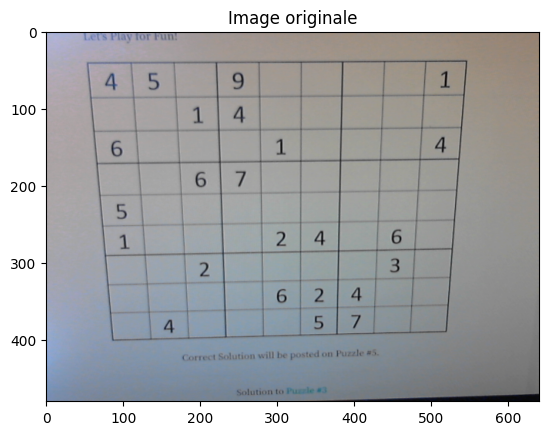

In [43]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

image_path = "c:\Image_save\sudoku_capture_2025-05-20_14-07-33.png"  # Il faut remplacer par la nouvelle image que tu veux tester
# image_path = "v1_training/image/image1006.jpg"  # Il faut remplacer par la nouvelle image que tu veux tester
image = cv2.imread(image_path)
# Afficher l'image originale 
plt.figure()
plt.title("Image originale")
# Convertir l'image en RGB pour l'affichage avec matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


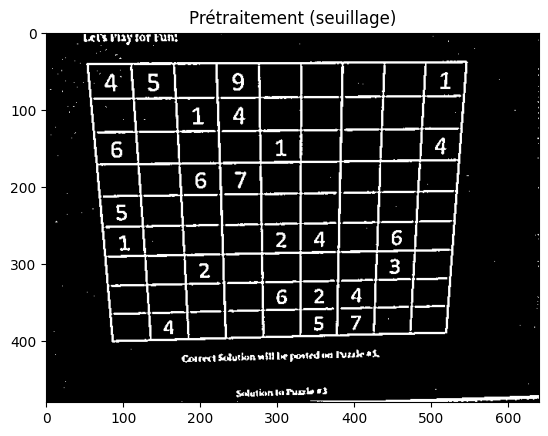

In [44]:
# Fonction de prétraitement de l'image
def pretraitement(image):
    # Convertit l'image en niveaux de gris pour simplifier le traitement.
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Réduit les petits bruits ou variations (comme les ombres ou pixels isolés).
    blur = cv2.GaussianBlur(gris, (3, 3), 6)
    #Transforme l’image floue en noir et blanc, pixel par pixel, en s’adaptant à la luminosité.
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

threshold = pretraitement(image)

plt.figure()
plt.title("Prétraitement (seuillage)")
plt.imshow(threshold, cmap='gray')
plt.show()


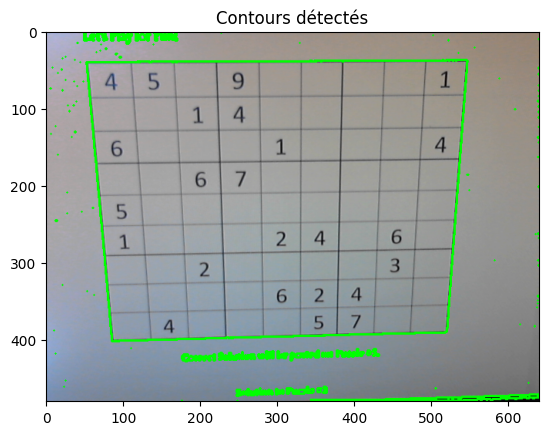

In [45]:
# On crée une copie de l’image couleur pour dessiner par-dessus sans modifier l’originale.
contour_debug = image.copy()
# Détection des contours dans l'image prétraitée.
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# On dessine les contours détectés sur la copie de l'image.
cv2.drawContours(contour_debug, contours, -1, (0, 255, 0), 2)

plt.figure()
plt.title("Contours détectés")
plt.imshow(cv2.cvtColor(contour_debug, cv2.COLOR_BGR2RGB))
plt.show()


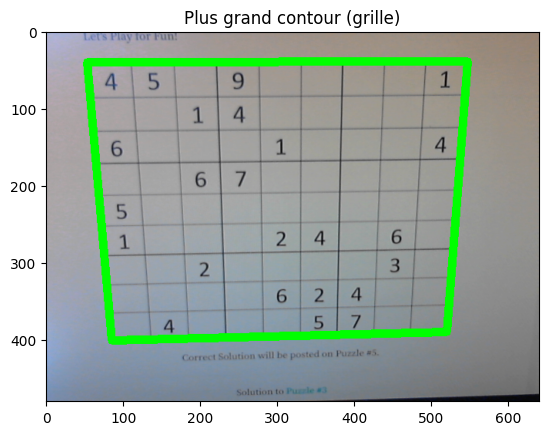

In [46]:

# Fonction pour trouver le plus grand contour qui ressemble à un quadrilatère (comme une grille de sudoku)
def trouver_plus_grand_contour(contours):
    # Stocker le plus grand contour trouvé
    biggest = None
    # mémorise le plus grand contour trouvé jusqu'ici
    max_area = 0
    # Parcourir tous les contours détectés
    for c in contours:
        area = cv2.contourArea(c)
        # On ne garde que les contours dont la surface est significative (plus de 100 pixels)
        if area > 100:
            perimètre = cv2.arcLength(c, True)
            # approx contiendra typiquement 4 points si c’est un rectangle/quadrilatère
            approx = cv2.approxPolyDP(c, 0.02 * perimètre, True)
            if area > max_area and len(approx) == 4:
                # On garde le contour s’il est plus grand que le précédent
                biggest = approx
                max_area = area
    return biggest
biggest = trouver_plus_grand_contour(contours)
contour_red = image.copy()

# Si un contour quadrilatère a été trouvé, on le dessine en vert sur l'image originale
if isinstance(biggest, np.ndarray) and biggest.shape[0] == 4:
    cv2.drawContours(contour_red, [biggest], -1, (0, 255, 0), 10)

    plt.figure()
    plt.title("Plus grand contour (grille)")
    # Convertir l'image en RGB pour l'affichage avec matplotlib
    plt.imshow(cv2.cvtColor(contour_red, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Aucun contour quadrilatère détecté")


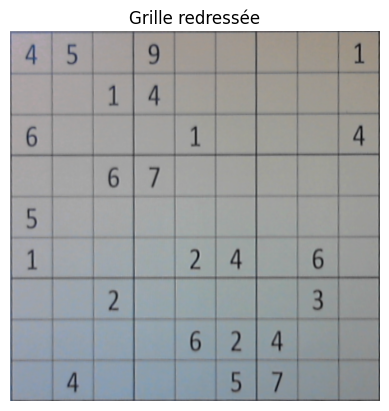

In [47]:
# Fonctione de réorganisation des points du quadrilatère pour les mettre dans l'ordre
def reorder(points):
    # On s'assure que les points sont dans un format approprié
    points = points.reshape((4, 2))
    # On crée un tableau pour les nouveaux points réordonnés
    points_new = np.zeros((4, 1, 2), dtype=np.int32)
    # Calcule la somme et la différence des coordonnées pour identifier les coins
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)] # Coin supérieur gauche
    points_new[3] = points[np.argmax(add)] # Coin inférieur droit
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)] # Coin supérieur droit
    points_new[2] = points[np.argmax(diff)] # Coin inférieur gauche
    return points_new

# Si on a trouvé un contour quadrilatère, on le réorganise pour la transformation perspective
if biggest is not None and len(biggest) == 4:
    biggest = reorder(biggest)
    pts1 = np.float32(biggest)
    # On définit les points de destination pour la transformation perspective
    pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
    # On crée la matrice de transformation perspective pour redresser la grille
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    # On applique la transformation à l'image
    imagewrap = cv2.warpPerspective(image, matrix, (450, 450))
    # Convertir l'image redressée en RGB pour l'affichage
    imagewrap = cv2.cvtColor(imagewrap, cv2.COLOR_BGR2RGB)

    plt.figure()
    plt.title("Grille redressée")
    plt.imshow(imagewrap)
    plt.axis('off')
    plt.show()
else:
    print("Grille non trouvée pour transformation")


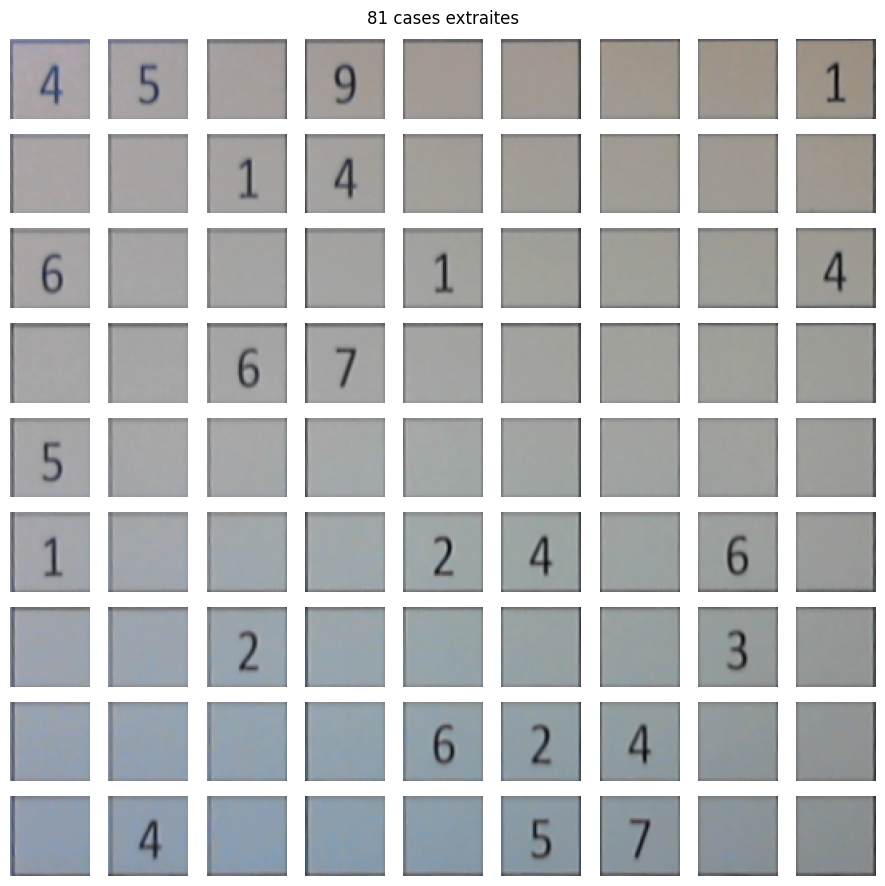

In [48]:
def decouper_grille_en_cases(grille_image):
    # Découpe une grille 450x450 en 81 images 50x50. 
    cases = []
    taille_case = grille_image.shape[0] // 9  # 450 // 9 = 50

    for y in range(9):
        for x in range(9):
            x1 = x * taille_case
            y1 = y * taille_case
            case = grille_image[y1:y1+taille_case, x1:x1+taille_case]
            cases.append(case)
    return cases
cases = decouper_grille_en_cases(imagewrap)

# Affichage des 81 cases
plt.figure(figsize=(9, 9))
for i in range(81):
    plt.subplot(9, 9, i + 1)
    plt.imshow(cases[i], cmap='gray')
    plt.axis('off')
plt.suptitle("81 cases extraites")
plt.tight_layout()
plt.show()



## Création du modèle qui détecte les chiffres 


In [50]:
df = pd.read_csv('dataset_chiffre_r.csv')


In [51]:
df

,images,category
0,dataset_chiffre/0/img001-00001.png,0
1,dataset_chiffre/0/img001-00002.png,0
2,dataset_chiffre/0/img001-00003.png,0
3,dataset_chiffre/0/img001-00004.png,0
4,dataset_chiffre/0/img001-00005.png,0
...,...,...
10155,dataset_chiffre/9/img010-01012.png,9
10156,dataset_chiffre/9/img010-01013.png,9
10157,dataset_chiffre/9/img010-01014.png,9
10158,dataset_chiffre/9/img010-01015.png,9


In [52]:
df['category']

0        0
1        0
2        0
3        0
4        0
        ..
10155    9
10156    9
10157    9
10158    9
10159    9
Name: category, Length: 10160, dtype: int64

In [53]:
le = preprocessing.LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
print(y.shape)
print(list(le.inverse_transform([0, 1, 2])))

(10160,)
[np.int64(0), np.int64(1), np.int64(2)]


In [54]:
X = []
index = 0

for files in df.images: 
    X.append(cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2RGB))
    index = index+1

X = np.asarray(X)
print(X.shape)

(10160, 128, 128, 3)


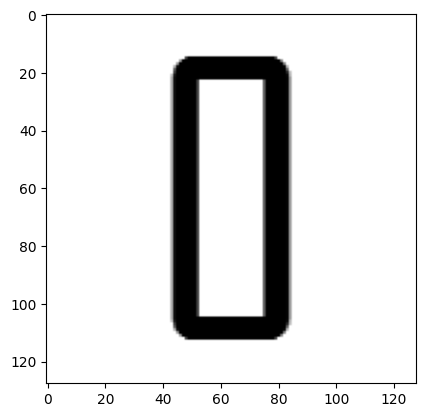

In [55]:
plt.imshow(X[0])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6807, 128, 128, 3)
(6807,)
(3353, 128, 128, 3)
(3353,)


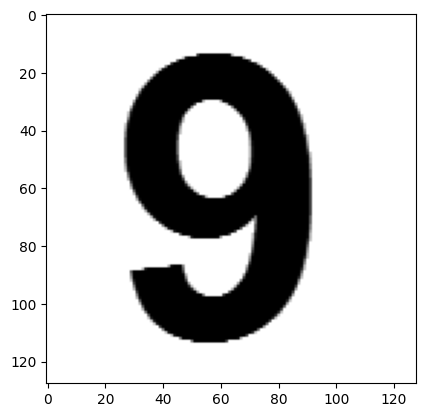

In [57]:
plt.imshow(X_train[10])


In [58]:
model = keras.models.Sequential()
  
model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))  # 10 classes pour chiffres

c:\Users\Clément\OneDrive - Haute Ecole de Namur-Liege-Luxembourg\Documents\Année M1\Système intelligent\r-solution-de-sudoku\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
model.summary()

model.compile(optimizer='adam',#function for get down the gradient
              loss='sparse_categorical_crossentropy',#loss function for classification
              metrics=['accuracy']) #the metric 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 400)            │     2,509,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         4,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,679,642 (10.22 MB)

 Trainable params: 2,679,642 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
%%time

batch_size  = 20
epochs      =  5
history = model.fit(  X_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1)
                    #   validation_data = (X_test, y_test))

Epoch 1/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.5304 - loss: 22.0003
Epoch 2/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9228 - loss: 0.2565
Epoch 3/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.9566 - loss: 0.1487
Epoch 4/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.9685 - loss: 0.0994
Epoch 5/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9740 - loss: 0.0917
CPU times: total: 5min 17s
Wall time: 1min 26s


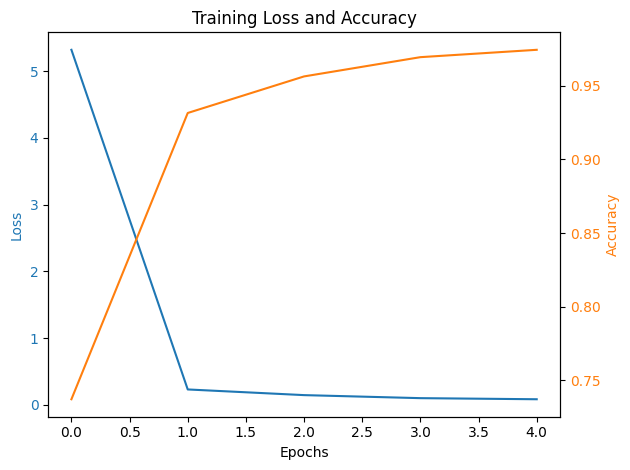

In [61]:
fig, ax1 = plt.subplots()   

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(history.history['loss'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:orange')
ax2.plot(history.history['accuracy'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

In [62]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0447
Test accuracy : 0.9848


In [63]:
y_sigmoid = model.predict(X_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


              precision    recall  f1-score   support

           0     0.9860    0.9916    0.9888       356
           1     0.9884    0.9688    0.9785       352
           2     0.9791    0.9880    0.9835       332
           3     0.9702    0.9849    0.9775       331
           4     0.9797    1.0000    0.9898       338
           5     0.9878    0.9908    0.9893       327
           6     0.9968    0.9574    0.9767       329
           7     0.9912    0.9883    0.9897       341
           8     0.9702    0.9909    0.9805       329
           9     1.0000    0.9874    0.9937       318

    accuracy                         0.9848      3353
   macro avg     0.9850    0.9848    0.9848      3353
weighted avg     0.9849    0.9848    0.9848      3353



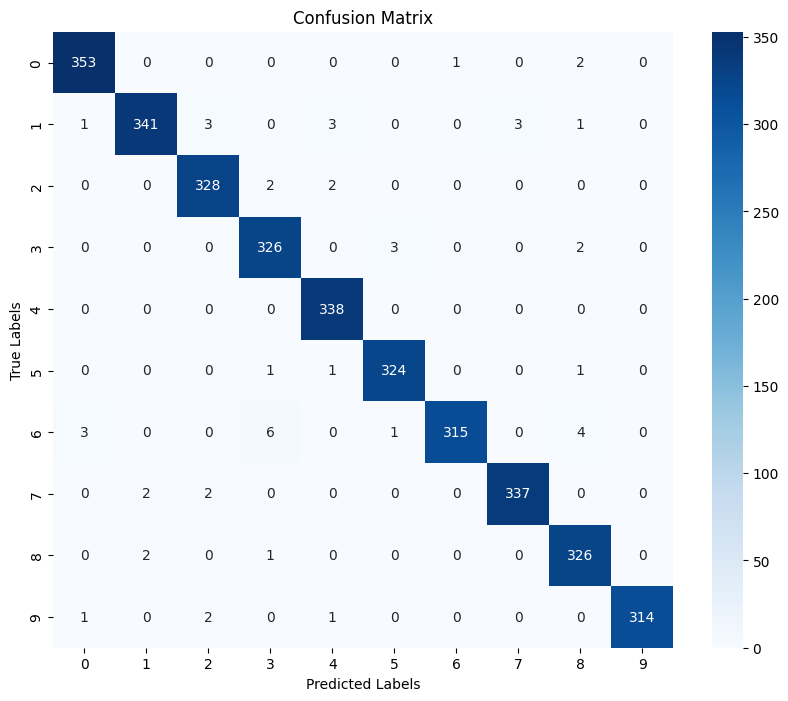

In [64]:
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [65]:
# YOU NEED TO CHANGE THE FILEPATH
model_path = "c:/Image_save/sudoku_model.keras"  # Chemin où le modèle sera sauvegardé
tf.keras.models.save_model(
    model,
    filepath = model_path,
    overwrite=True,
)

In [66]:
model2 = keras.models.load_model(model_path)